In [245]:
import datetime
import string

import alphalens as al
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [766]:
xs = np.linspace(0, 16 * np.pi, 16 * 25)
sin = np.sin(xs)
cos = np.cos(xs)

In [855]:
end = datetime.date.today() - datetime.timedelta(1)
start = end - datetime.timedelta(len(sin))
index = pd.date_range(start + datetime.timedelta(1), end).rename('date')

NUM_ASSETS = 2

In [856]:
alpha = pd.DataFrame()
for c in string.ascii_uppercase[:NUM_ASSETS]:
    xs = pd.DataFrame(index=index, data={'alpha': (cos if ord(c) % 2 else -sin), 'asset': c})
    alpha = alpha.append(xs)

# alpha.alpha += 0.001 * np.random.random(alpha.alpha.shape) - 0.0005
alpha = alpha.reset_index().sort_values(['date', 'asset']).set_index(['date', 'asset'])

In [857]:
prices = pd.DataFrame(index=index)
for c in string.ascii_uppercase[:NUM_ASSETS]:
    prices[c] = 100 + (sin if ord(c) % 2 else cos)

# prices += 0.1 * np.random.random(prices.shape) - 0.05

In [858]:
factor = al.utils.get_clean_factor_and_forward_returns(alpha, prices, quantiles=2, periods=[1, 2, 5, 12, 25, 30], zero_aware=True) # , max_loss=0)

Dropped 7.5% entries from factor data: 7.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


<Figure size 640x480 with 0 Axes>

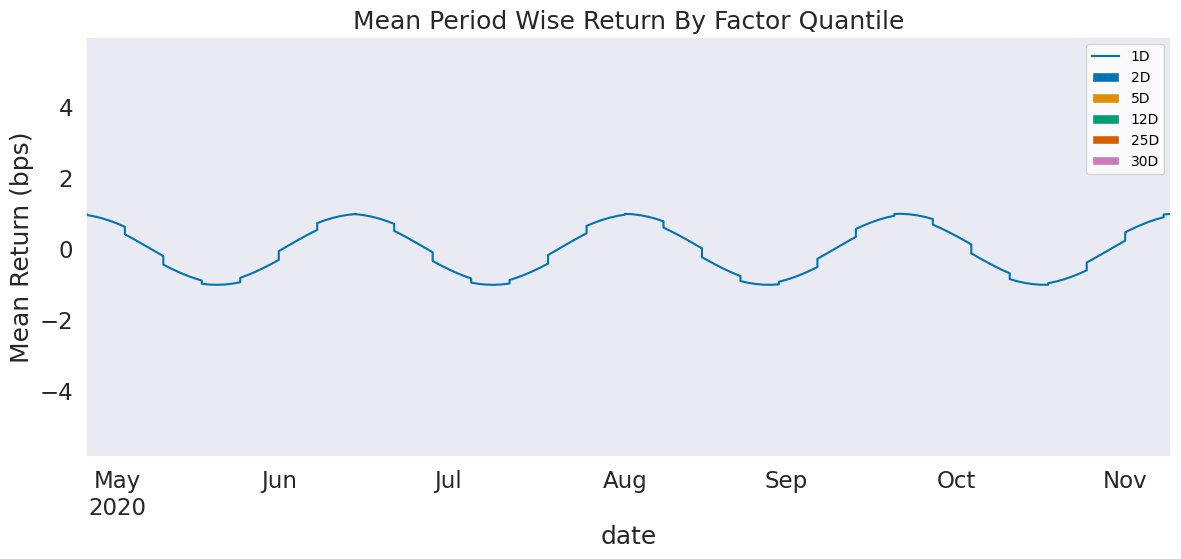

In [859]:
# For some reason get_clean_factor() makes the signal jerky.
# TODO: Inspect!
factor['factor'].loc[:,'A'].iloc[:200].plot(); plt.show()

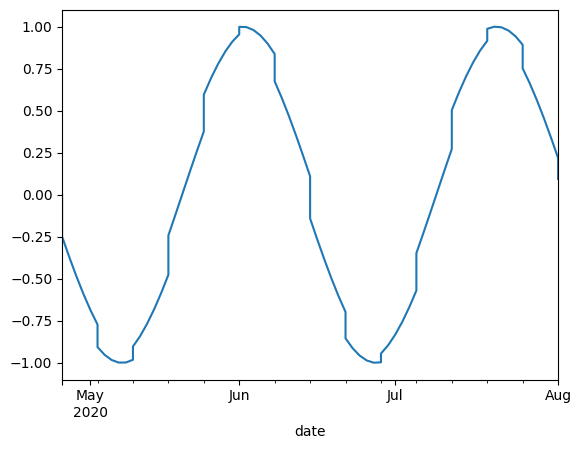

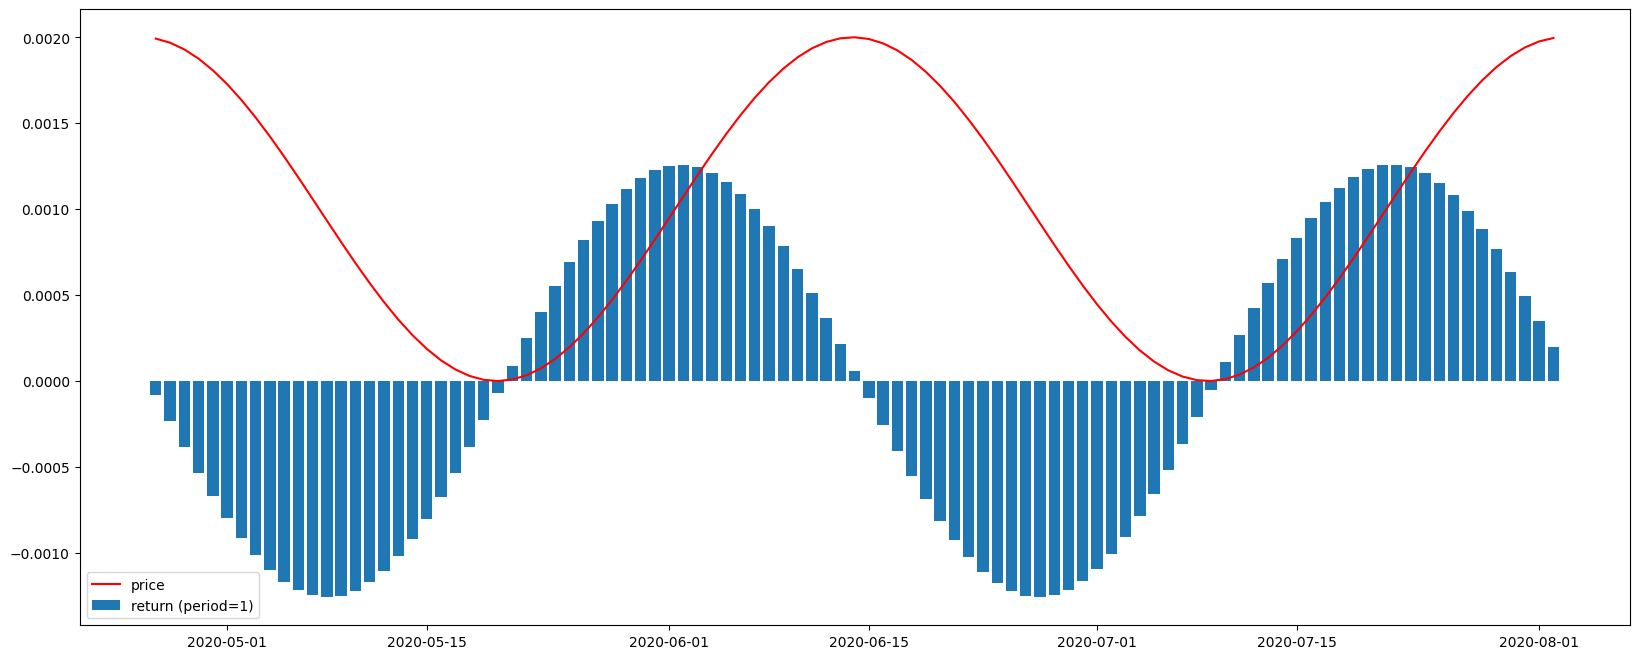

In [860]:
factor.factor.loc[:,'B'].iloc[:100].plot();
visualize_returns(prices.B.iloc[:100], figsize=(20, 8))

In [861]:
def visualize_returns(ps, period=1, figsize=None):
    from sklearn.preprocessing import MinMaxScaler

    rs = ps.pct_change(period)
    xs = pd.DataFrame(data={'price': ps, 'return': rs}).dropna()

    scaler = MinMaxScaler(feature_range=(0, 0.002))
    scaled = scaler.fit_transform(xs['price'].to_numpy().reshape(-1, 1))
    if figsize:
        plt.figure(figsize=figsize)
    plt.bar(xs.index, xs['return'], label=f'return (period={period})')
    plt.plot(xs.index, scaled, label='price', color='red')
    plt.legend()
    plt.show()

In [862]:
# a = factor.loc[(slice(None), 'A'),:]
# a = a[a.factor_quantile == 2].factor
# a = a.unstack('asset')
# plt.plot(a); plt.show()

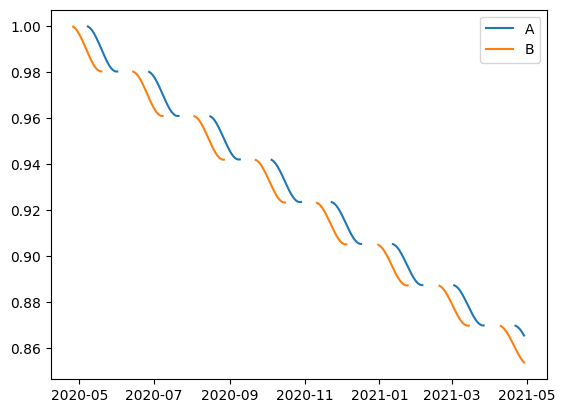

In [915]:
# factor[factor.factor_quantile==1]['1D'].unstack()[['A', 'B']].add(1).cumprod().plot(); plt.show();

xs = factor[factor.factor_quantile==1]['1D'].unstack()[['A', 'B']].add(1).cumprod()
plt.plot(xs.index, xs.A, label='A')
plt.plot(xs.index, xs.B, label='B')
plt.legend()
plt.show()

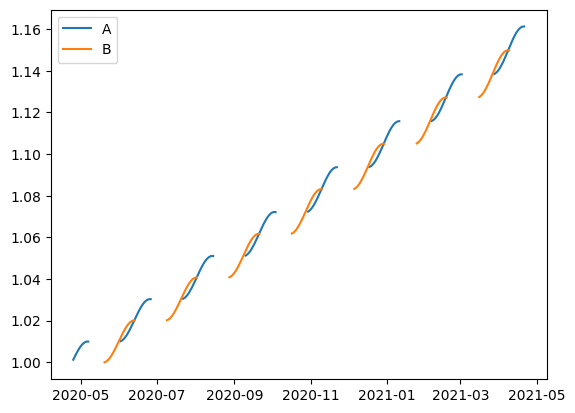

In [864]:
xs = factor[factor.factor_quantile==2]['1D'].unstack()[['A', 'B']].add(1).cumprod()
plt.plot(xs.index, xs.A, label='A')
plt.plot(xs.index, xs.B, label='B')
plt.legend()
plt.show()

In [865]:
# xs = factor[factor.factor_quantile == 2]
# xs = xs[xs['1D'] < 0]
# xs

In [866]:
# factor.loc['2020-05-18':'2020-05-19']

In [889]:
xs, _ = al.performance.mean_return_by_quantile(factor, demeaned=True)
xs

,1D,2D,5D,12D,25D,30D
factor_quantile,,,,,,
1,-0.000530,-0.001052,-0.002486,-0.004211,0.000037,0.002516
2,0.000544,0.001079,0.002549,0.004319,-0.000038,-0.002580


In [892]:
print('expected annual return:', np.power(0.000544 + 1, 252))

expected annual return: 1.146886323520697


In [868]:
# al.plotting.plot_cumulative_returns(factor, '1 days')

In [869]:
# al.performance.average_cumulative_return_by_quantile(factor)

In [870]:
# al.tears.create_summary_tear_sheet(factor)

<Figure size 640x480 with 0 Axes>

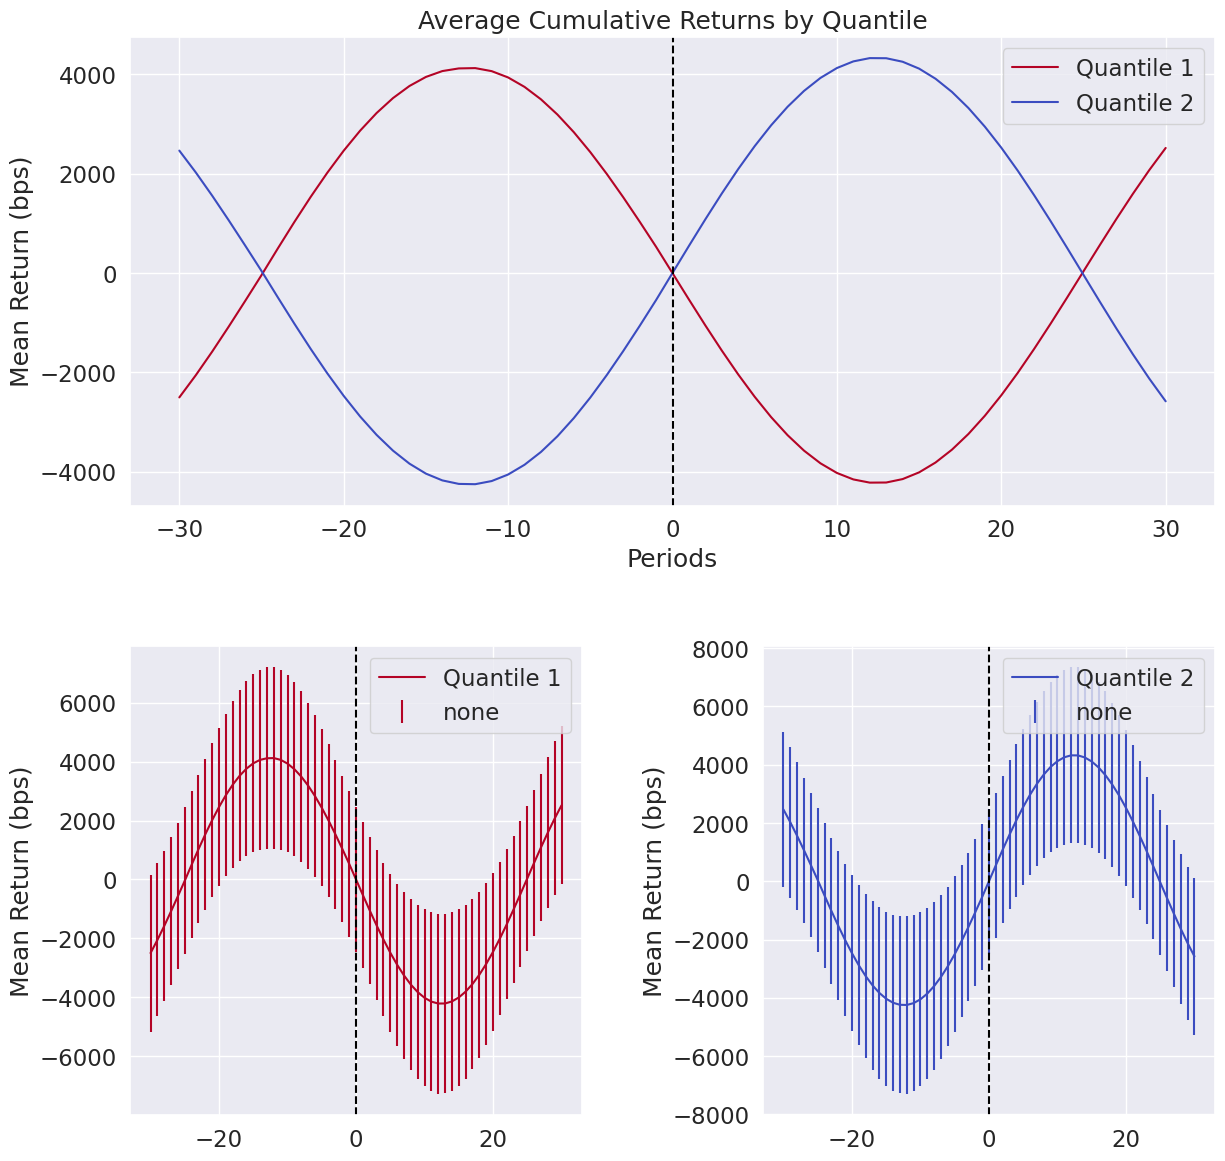

In [913]:
al.tears.create_event_returns_tear_sheet(factor, prices, avgretplot=(30, 30), long_short=True)

In [872]:
al.tears.create_summary_tear_sheet(factor)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.999992,-0.003937,-0.637892,0.306401,377,50.945946
2,-0.000000,1.000000,0.635563,0.309456,363,49.054054


Returns Analysis


,1D,2D,5D,12D,25D,30D
Ann. alpha,0.154,0.152,0.142,0.097,-0.002,-0.024
beta,0.014,0.014,0.015,0.014,0.009,0.008
Mean Period Wise Return Top Quantile (bps),5.438,5.393,5.093,3.592,-0.015,-0.861
Mean Period Wise Return Bottom Quantile (bps),-5.303,-5.262,-4.976,-3.516,0.015,0.838
Mean Period Wise Spread (bps),15.993,15.866,14.994,10.585,-0.044,-2.530


Information Analysis


,1D,2D,5D,12D,25D,30D
IC Mean,0.957,0.919,0.795,0.508,-0.016,-0.216
IC Std.,0.291,0.395,0.608,0.862,1.001,0.978
Risk-Adjusted IC,3.285,2.326,1.307,0.589,-0.016,-0.221
t-stat(IC),63.181,44.751,25.140,11.332,-0.312,-4.254
p-value(IC),0.000,0.000,0.000,0.000,0.756,0.000
IC Skew,-6.578,-4.659,-2.617,-1.180,0.032,0.443
IC Kurtosis,41.272,19.709,4.851,-0.608,-1.999,-1.804


TypeError: object of type 'float' has no len()

In [873]:
al.tears.create_summary_tear_sheet(factor, long_short=False)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.999992,-0.003937,-0.637892,0.306401,377,50.945946
2,-0.000000,1.000000,0.635563,0.309456,363,49.054054


Returns Analysis


,1D,2D,5D,12D,25D,30D
Ann. alpha,0.285,0.283,0.265,0.180,-0.001,-0.039
beta,0.002,0.003,0.004,0.004,0.000,-0.002
Mean Period Wise Return Top Quantile (bps),7.965,7.880,7.385,5.086,-0.209,-1.406
Mean Period Wise Return Bottom Quantile (bps),-8.034,-7.995,-7.628,-5.533,-0.196,1.102
Mean Period Wise Spread (bps),15.993,15.866,14.995,10.588,-0.045,-2.531


Information Analysis


,1D,2D,5D,12D,25D,30D
IC Mean,0.957,0.919,0.795,0.508,-0.016,-0.216
IC Std.,0.291,0.395,0.608,0.862,1.001,0.978
Risk-Adjusted IC,3.285,2.326,1.307,0.589,-0.016,-0.221
t-stat(IC),63.181,44.751,25.140,11.332,-0.312,-4.254
p-value(IC),0.000,0.000,0.000,0.000,0.756,0.000
IC Skew,-6.578,-4.659,-2.617,-1.180,0.032,0.443
IC Kurtosis,41.272,19.709,4.851,-0.608,-1.999,-1.804


TypeError: object of type 'float' has no len()

Returns Analysis


,1D,2D,5D,12D,25D,30D
Ann. alpha,0.285,0.283,0.265,0.180,-0.001,-0.039
beta,0.002,0.003,0.004,0.004,0.000,-0.002
Mean Period Wise Return Top Quantile (bps),7.965,7.880,7.385,5.086,-0.209,-1.406
Mean Period Wise Return Bottom Quantile (bps),-8.034,-7.995,-7.628,-5.533,-0.196,1.102
Mean Period Wise Spread (bps),15.993,15.866,14.995,10.588,-0.045,-2.531


<Figure size 640x480 with 0 Axes>

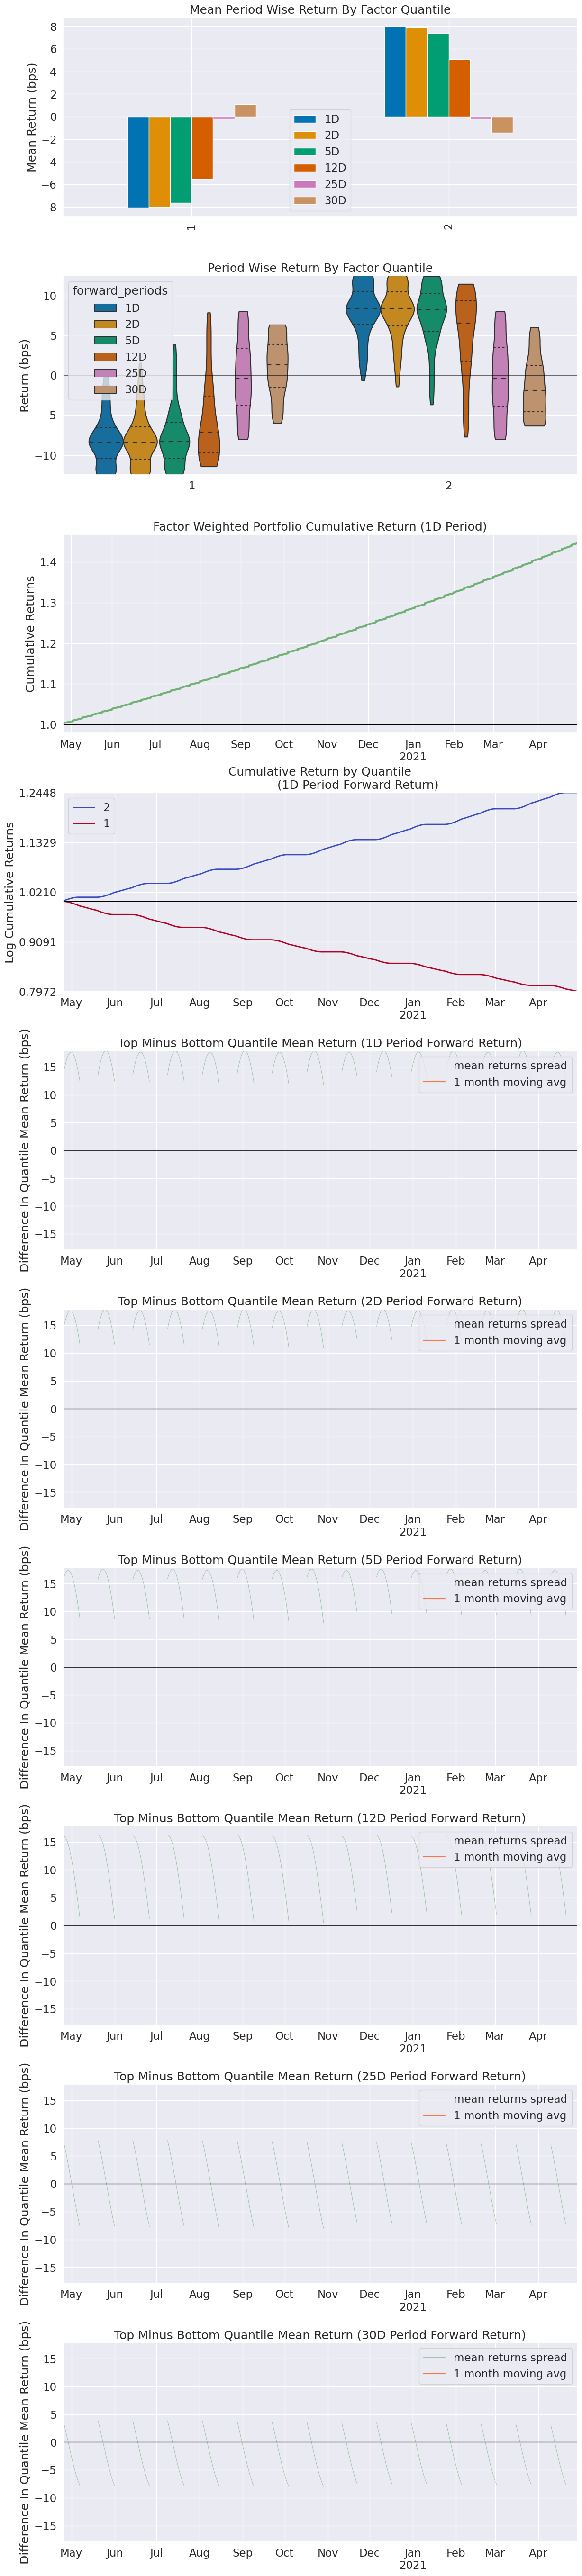

In [904]:
al.tears.create_returns_tear_sheet(factor, long_short=False)